In [1]:
# Import the libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import PowerTransformer

pd.options.display.max_rows = 200

def Find_Optimal_Cutoff(target, predicted):
    '''Find data-driven cut-off for classification
    
    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    target : array, shape = [n_samples]
        True binary labels.
        
    predicted : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(data_final):
    feature_list_for_training = [
        'sex_M',
        'age_18-29', 'age_40-49', 'age_50-59', 'age_60+',
        'substance',
        'mood',
        'anxiety',
        'psychotic',
        'cognitive',
        'otherpsych',
        'selfharm',
        'visit_emr_MH_non_elect',
        'visit_emr_NonMH',
        'visit_emr_visit',
        'visit_hosp_visit',
        'visit_hospitalized_MH',
        'visit_hospitalized_NonMH',
        'visit_family_gp',
        'visit_im',
        'visit_neurology',
        'visit_other',
        'visit_psychiatry',
        'EX_CHF',
        'EX_Arrhy',
        'EX_VD',
        'EX_PCD',
        'EX_PVD',
        'EX_HPTN_UC',
        'EX_HPTN_C',
        'EX_Para',
        'Ex_OthND',
        'Ex_COPD',
        'Ex_Diab_UC',
        'Ex_Diab_C',
        'Ex_Hptothy',
        'Ex_RF',
        'Ex_LD',
        'Ex_PUD_NB',
        'Ex_HIV',
        'Ex_Lymp',
        'Ex_METS',
        'Ex_Tumor',
        'Ex_Rheum_A',
        'Ex_Coag',
        'Ex_Obesity',
        'Ex_WL',
        'Ex_Fluid',
        'Ex_BLA',
        'Ex_DA',
        'Ex_Alcohol',
        'Ex_Drug',
        'Ex_Psycho',
        'Ex_Dep',
        'Ex_Stroke',
        'Ex_Dyslipid',
        'Ex_Sleep',
        'Ex_IHD',
        'EX_Fall',
        'EX_Urinary',
        'EX_Visual',
        'EX_Hearing',
        'EX_Tobacco',
        'EX_Delirium',
        'Ex_MS',
        'EX_parkinsons',
    ]
    
    # Separate the features for training
    X = data_final[feature_list_for_training]
    # Separate the labels for training
    y = data_final['homeless_followup']
    
    # Add the constant to the X features
    X = sm.add_constant(X)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the logistic regression model
    log_reg = sm.Logit(y_train, X_train).fit()

    # Make predictions on the test set
    yhat = log_reg.predict(X_test)
    
    # Find optimal probability threshold by using the yhat as a continuous measure
    threshold = Find_Optimal_Cutoff(y_test, yhat)

    # Convert probabilities to binary predictions using the threshold
    prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)
    
    # Calculate evaluation metrics
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    sensitivity = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)

    # Create a DataFrame to store the results
    df_results = pd.DataFrame((round(f1, 2), round(roc_auc, 2), round(sensitivity, 2), round(precision, 2)))
    df_results = df_results.T
    
    return (df_results, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, y)

# Read the data into a DataFrame
data_final = pd.read_hdf('data/df_subjects_retro_homelss_preproc.h5', 'df_subjects_retro_homelss_preproc')

print ("the unique values of the 'homeless_followup' column in the data")
print(data_final['homeless_followup'].unique())


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


the unique values of the 'homeless_followup' column in the data
[0 1]


In [4]:
data_final['age']=data_final['age'].map(lambda x: int(x))

In [5]:
df_results,X_train, X_test, y_train, y_test,prediction,log_reg,feature_list_for_training,y=train_model(data_final)

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.032604
         Iterations 11


In [6]:
df_results.columns=['f1','roc_auc','sensitivity','precision']

In [7]:
df_results

,f1,roc_auc,sensitivity,precision
0,0.07,0.83,0.82,0.04


Confusion Matrix : 
 [[20082  3514]
 [   30   135]]
Test accuracy =  0.850848028281638
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     23596
           1       0.04      0.82      0.07       165

    accuracy                           0.85     23761
   macro avg       0.52      0.83      0.49     23761
weighted avg       0.99      0.85      0.91     23761

F1 Score: 0.07079181961195595
AUC: 0.83%


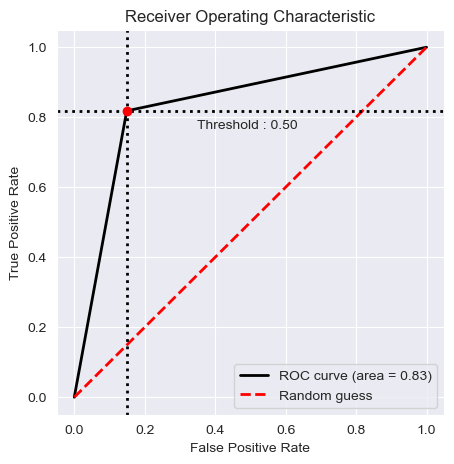

In [8]:
# confusion matrix for the test dataset
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

print(classification_report(y_test, prediction))

print("F1 Score: {}".format(f1_score(y_test, prediction)))

roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")



# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction, labels = ["Class 1", "Class 2"])

# Figures
plt.figure(figsize = (5,5))
bc.plot_roc_curve()
plt.show()

In [19]:
result=log_reg
df_results=np.round(np.exp(result.conf_int()),2)
df_results.columns=['2.5%','97.5%']
df_results['OR']=pd.DataFrame(np.exp(result.params))
df_results['OR']=df_results['OR'].map(lambda x: np.round(x,2))
df_results['P_value']=np.round(result.pvalues.values,2)


In [20]:
df_results[['OR','2.5%', '97.5%', 'P_value']].sort_values("OR",ascending=False)

,OR,2.5%,97.5%,P_value
visit_emr_NonMH,4.21,3.02,5.86,0.00
substance,3.70,3.09,4.43,0.00
visit_emr_MH_non_elect,3.33,2.89,3.83,0.00
Ex_Drug,2.67,2.32,3.09,0.00
Ex_HIV,2.25,1.39,3.62,0.00
Ex_Lymp,2.01,1.08,3.73,0.03
Ex_Alcohol,1.61,1.41,1.84,0.00
Ex_Fluid,1.52,1.33,1.73,0.00
sex_M,1.51,1.35,1.69,0.00
EX_Fall,1.50,1.33,1.68,0.00
